In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

In [2]:
annotations = pd.read_csv('../data/annotations.csv')

In [3]:
# Get 70% of each class for training
train, test = train_test_split(annotations, test_size=0.3, random_state=42, stratify=annotations['class'])

# Get 15% of each class for testing and 15% for validating
test, val = train_test_split(test, test_size=0.5, random_state=42, stratify=test['class'])

In [4]:
# Create dict for mapping class names to numbers
class_dict = {class_name: i for i, class_name in enumerate(['A', 'B', 'E', 'G'])}

In [6]:
# Cast annotation format to YOLO format
def pascal_voc_to_yolo(x1, y1, x2, y2):
    return [((x2 + x1)/(2*512)), ((y2 + y1)/(2*512)), (x2 - x1)/512, (y2 - y1)/512]


In [7]:
# Save annotation
def save_annotation(row, file):
    res = pascal_voc_to_yolo(row[2], row[3], row[4], row[5])
    file.write(
        f"{class_dict[row[6]]} {res[0]} {res[1]} {res[2]} {res[3]}\n")


In [8]:
def create_dataset_split(df, name):
    if not os.path.exists('../data/' + name):
        os.makedirs('../data/' + name)
        os.makedirs('../data/' + name + '/images')
        os.makedirs('../data/' + name + '/labels')

    for line in df.values:
        os.system(
            'cp ../data/{}/{}.jpg ../data/{}/images/{}_{}.jpg'.format(
                line[0], line[1], name, line[0], line[1]))

        with open('../data/{}/labels/{}_{}.txt'.format(name, line[0], line[1]), 'w') as file:
            save_annotation(line, file)


In [9]:
create_dataset_split(train, 'train')
create_dataset_split(test, 'test')
create_dataset_split(val, 'val')

../data/val/images/E0004_1.jpg


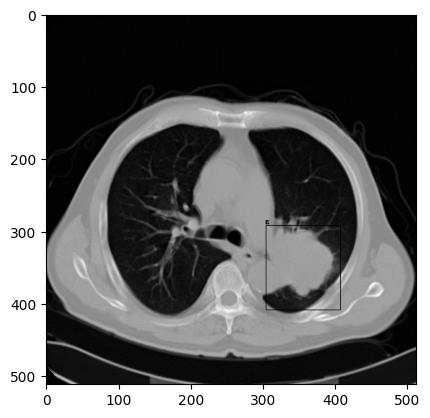

In [10]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h

    transformed_annotations[:, 1] = transformed_annotations[:,
                                                            1] - (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:,
                                                            2] - (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:,
                                                            1] + transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:,
                                                            2] + transformed_annotations[:, 4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        plotted_image.text((x0, y0 - 10), list(class_dict)[(int(obj_cls))])

    plt.imshow(np.array(image), cmap="Greys_r")
    plt.show()


# Get any random annotation file
annotation_file = "../data/val/labels/E0004_1.txt"
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x] for x in annotation_list]

# Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_list)
